In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [22]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")

Tesla K80


In [0]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


fashion_mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.2860,), (0.3530,)),
           ])

def make_mnist(l, batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path="./"):
    test_data = l(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = l(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path='./FashionMNIST_data'):
    return make_mnist(datasets.FashionMNIST, batch_size, valid, shuffle, transform, path)
  
def mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path='./MNIST_data'):
    return make_mnist(datasets.MNIST, batch_size, valid, shuffle, transform, path)  

def plot_mnist(images, shape):
    images = images[:50, :, :]
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor(), batch_size=200)

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
      
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, bn=False, activation_fn=nn.ReLU()):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)  
      
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc0 = nn.Linear(latent_size, 128)
        self.bn0 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, 28*28)
       
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.bn0(x)
        x = torch.tanh(x)
        x = self.fc1(x)
        x = torch.tanh(x)
        return x      
      
      
      
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)      

In [0]:
class Net(nn.Module):
    def __init__(self, latent_size=10, batchnorm=False, dropout=False, lr=1e-4, l2=0., loss_fn=F.mse_loss):
        super(Net, self).__init__()
        
        self.loss_fn = loss_fn
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, latent_size], dropout=dropout)
        
        self.D = Decoder(latent_size)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        x = torch.softmax(x, 0)
        x = self.D(x)
        return x
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [0]:
models = {'bn': Net(64, True).to(device)}#, 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            #rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data)# + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, 0))
        print(line + losses)

In [0]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += 0#m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
#        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], 0))#rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [76]:
for epoch in range(1, 121):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 0.020247
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.020217
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.020159
Test set:
bn: loss: 0.0199	rho_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.020202
Train Epoch: 2 [40000/50000 (80%)]	Losses bn: 0.019584
Train Epoch: 2 [50000/50000 (100%)]	Losses bn: 0.019070
Test set:
bn: loss: 0.0191	rho_loss: 0.0000

Train Epoch: 3 [0/50000 (0%)]	Losses bn: 0.018431
Train Epoch: 3 [40000/50000 (80%)]	Losses bn: 0.017642
Train Epoch: 3 [50000/50000 (100%)]	Losses bn: 0.017507
Test set:
bn: loss: 0.0183	rho_loss: 0.0000

Train Epoch: 4 [0/50000 (0%)]	Losses bn: 0.017928
Train Epoch: 4 [40000/50000 (80%)]	Losses bn: 0.017568
Train Epoch: 4 [50000/50000 (100%)]	Losses bn: 0.017691
Test set:
bn: loss: 0.0176	rho_loss: 0.0000

Train Epoch: 5 [0/50000 (0%)]	Losses bn: 0.017018
Train Epoch: 5 [40000/50000 (80%)]	Losses bn: 0.016422
Train Epoch: 5 [50000/50000 (100%)]	Losses bn: 0.016319
Test set:
bn: l

KeyboardInterrupt: ignored

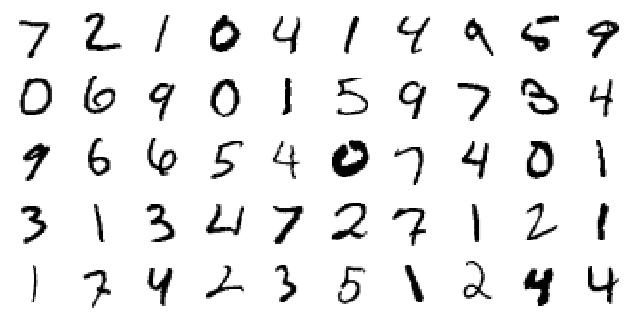

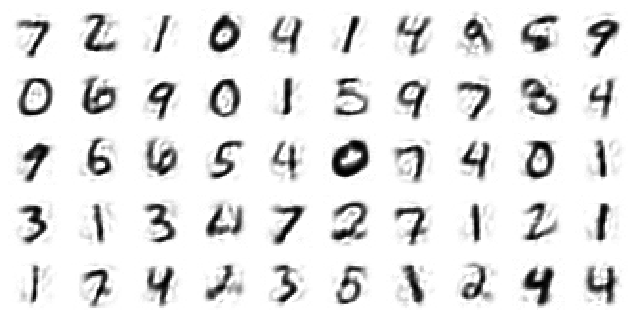

In [77]:
data, _ = next(iter(test_loader))
output = models['bn'](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))